<a href="https://www.kaggle.com/code/sevdanuropur/book-recommendation-system-user-based-item-based?scriptVersionId=164440263" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# BOOK RECOMMENDATION SYSTEM

<font color = 'blue'>
    
# Content:
1. [Dataset](#1)
1. [What is Recommendation System](#2)
1. [Aim of the Project](#3)
1. [Import Libraries](#4)
1. [Understand Data](#5)
1. [Let's Try](#6)
1. [Result](#7)
1. [Conclusion](#8)   
    


<a id = "1"></a><br>

# Dataset

* Users
Contains the users. Note that user IDs (User-ID) have been anonymized and map to integers. Demographic data is provided (Location, Age) if available. Otherwise, these fields contain NULL-values.
* Books
Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (Book-Title, Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web Services.
* Ratings
Contains the book rating information. Ratings (Book-Rating) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

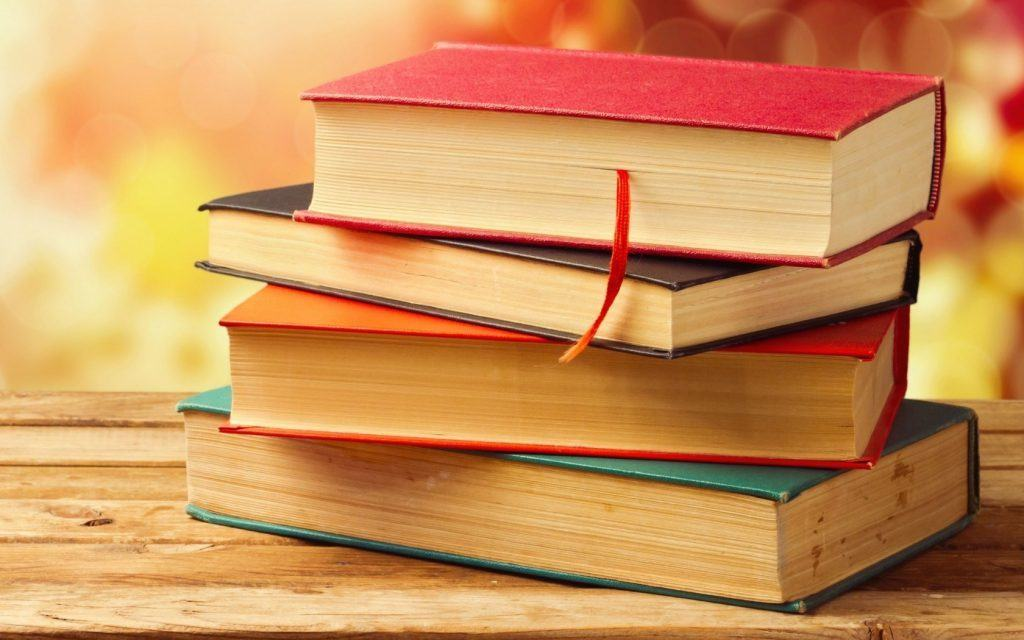

<a id = "2"></a><br>

# What is Recommendation System ?

A recommendation system is an information filtering or algorithmic system that suggests specific items to users. These systems analyze users' past preferences, behaviors, or similar users' preferences to make recommendations. For example, on an e-commerce site, it can suggest similar products based on a user's previous shopping history and interests. Recommendation systems can operate using content-based, collaborative, or hybrid methods. These systems are widely used on various platforms to enhance user experience, stimulate sales, and personalize content.

<a id = "3"></a><br>

# Aim of the Project 

In this project, we will recommend books to a selected user by leveraging the reviews of users with high correlation to the chosen user. During this process, recommendations will be made based on the books reviewed by users who exhibit a strong correlation with the selected user. This approach involves utilizing collaborative filtering, where the analysis of book reviews helps identify similar users with whom the chosen user shares high correlation. Subsequently, book recommendations from these correlated users will be used to suggest books to the selected user. This method allows the user to discover books liked by individuals with similar preferences, enhancing the personalization of the recommendation experience.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/book-recommendation-dataset/Ratings.csv
/kaggle/input/book-recommendation-dataset/Users.csv
/kaggle/input/book-recommendation-dataset/classicRec.png
/kaggle/input/book-recommendation-dataset/Books.csv
/kaggle/input/book-recommendation-dataset/DeepRec.png
/kaggle/input/book-recommendation-dataset/recsys_taxonomy2.png


<a id = "4"></a><br>

# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, \
    pearsonr, spearmanr, kendalltau, f_oneway, kruskal
from statsmodels.stats.proportion import proportions_ztest
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [3]:
book=pd.read_csv("/kaggle/input/book-recommendation-dataset/Books.csv")
ratings=pd.read_csv("/kaggle/input/book-recommendation-dataset/Ratings.csv")
user=pd.read_csv("/kaggle/input/book-recommendation-dataset/Users.csv")

<a id = "5"></a><br>

# Understand Data

In [4]:
book.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [5]:
book.shape

(271360, 8)

In [6]:
 book.nunique()

ISBN                   271360
Book-Title             242135
Book-Author            102022
Year-Of-Publication       202
Publisher               16807
Image-URL-S            271044
Image-URL-M            271044
Image-URL-L            271041
dtype: int64

In [7]:
# This means there is more than one ISBN number for a book.
book.groupby("Book-Title").agg({"ISBN":"count"}).sort_values("ISBN",ascending=False).head(10)

,ISBN
Book-Title,
Selected Poems,27
Little Women,24
Wuthering Heights,21
Dracula,20
Adventures of Huckleberry Finn,20
The Secret Garden,20
Jane Eyre,19
The Night Before Christmas,18
Pride and Prejudice,18


In [8]:
# let's combine these two dataframes
merged_df=book.merge(ratings, how="left", on="ISBN")

In [9]:
# We see that the percentage of 0 given to some books is quite high.
merged_df["Book-Rating"].value_counts()

Book-Rating
0.0000     647294
8.0000      91804
10.0000     71225
7.0000      66402
9.0000      60778
5.0000      45355
6.0000      31687
4.0000       7617
3.0000       5118
2.0000       2375
1.0000       1481
Name: count, dtype: int64

In [10]:
# How many books has a user commented? Let's look at the 10 users who commented the most.
merged_df.groupby("User-ID").agg({"Book-Title":"count"}).sort_values("Book-Title",ascending=False).head(10)

,Book-Title
User-ID,
11676.0000,11144
198711.0000,6456
153662.0000,5814
98391.0000,5779
35859.0000,5646
212898.0000,4289
278418.0000,3996
76352.0000,3329
110973.0000,2971


In [11]:
# What are the most commented books?
merged_df.groupby("Book-Title").agg({"Book-Rating":"count"}).sort_values("Book-Rating", ascending=False).head(5) 

,Book-Rating
Book-Title,
Wild Animus,2502
The Lovely Bones: A Novel,1295
The Da Vinci Code,898
A Painted House,838
The Nanny Diaries: A Novel,828


In [12]:
new=merged_df.groupby("Book-Title").agg({"Book-Rating":["count","mean"]}) 
new.head(5)

Book-Rating       
                                                         count   mean
Book-Title                                                           
A Light in the Storm: The Civil War Diary of Am...           4 2.2500
Always Have Popsicles                                        1 0.0000
Apple Magic (The Collector's series)                         1 0.0000
Ask Lily (Young Women of Faith: Lily Series, Bo...           1 8.0000
Beyond IBM: Leadership Marketing and Finance fo...           1 0.0000

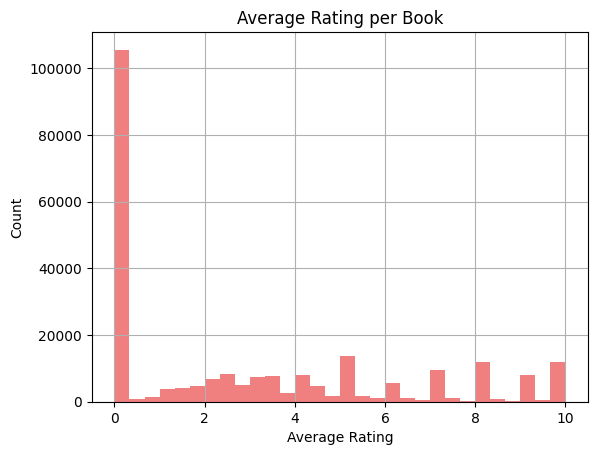

In [13]:
avg_rating_per_book = merged_df.groupby('Book-Title')['Book-Rating'].mean()
avg_rating_per_book.hist(bins=30, color='lightcoral')
plt.title('Average Rating per Book')
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.show()

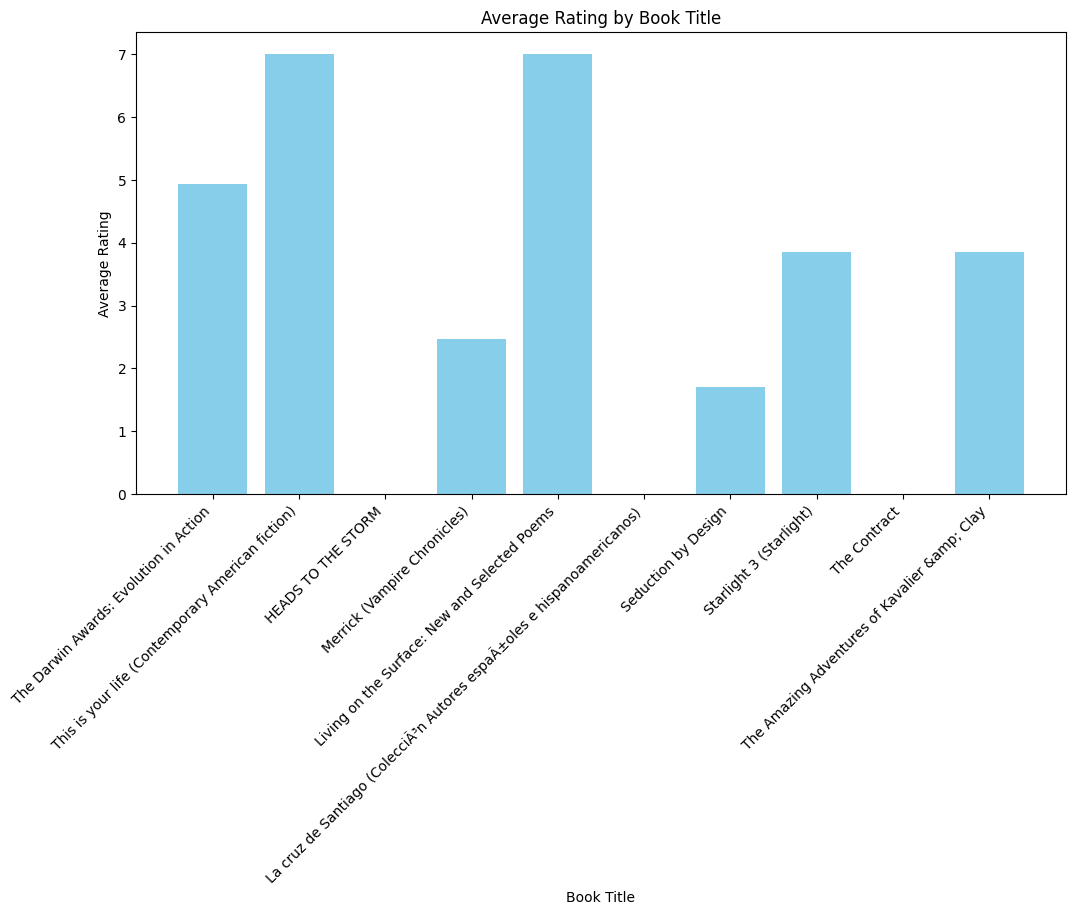

In [14]:
import matplotlib.pyplot as plt
import numpy as np

sample_book = merged_df['Book-Title'].sample(10)
average_ratings = [merged_df[merged_df['Book-Title'] == book]['Book-Rating'].mean() for book in sample_book]

plt.figure(figsize=(12, 6))
plt.bar(sample_book, average_ratings, color='skyblue')

plt.xticks(rotation=45, ha='right')
plt.xlabel('Book Title')
plt.ylabel('Average Rating')
plt.title('Average Rating by Book Title')


plt.show()

In [15]:
merged_df[merged_df["Book-Title"]=="The Open Door"][["Book-Rating"]]

,Book-Rating
912250,0.0000


In [16]:
# How many people have read the books reviewed with an average rating of 0 or 2?
new=merged_df.groupby("Book-Title").agg({"Book-Rating":["count","mean"]})  
new=new.droplevel(0, axis=1)
new.head()

,count,mean
Book-Title,,
"A Light in the Storm: The Civil War Diary of Amelia Martin, Fenwick Island, Delaware, 1861 (Dear America)",4,2.2500
Always Have Popsicles,1,0.0000
Apple Magic (The Collector's series),1,0.0000
"Ask Lily (Young Women of Faith: Lily Series, Book 5)",1,8.0000
Beyond IBM: Leadership Marketing and Finance for the 1990s,1,0.0000


In [17]:
new[new["mean"]<2][["count"]].sort_values("count",ascending=False).head(10)

,count
Book-Title,
Wild Animus,2502
Slow Waltz in Cedar Bend,248
Songs in Ordinary Time (Oprah's Book Club (Paperback)),232
Primary Colors: A Novel of Politics,166
The Cardinal of the Kremlin (Jack Ryan Novels),166
Moo,159
The Reef,154
The Burden of Proof,153
4 Blondes,151


In [18]:
# # for example, the number of people who voted for this book is high, but the average is very low
merged_df[merged_df["Book-Title"]=="Wild Animus"][["Book-Rating"]].head(10)

,Book-Rating
769,0.0000
770,0.0000
771,0.0000
772,2.0000
773,0.0000
774,0.0000
775,0.0000
776,0.0000
777,0.0000
778,0.0000


In [19]:
# Let's find the number of comments made on each book.
new_df=pd.DataFrame(merged_df["Book-Title"].value_counts())

In [20]:
# Let's choose books with less than 200 comments
selected_book=new_df[new_df["count"]<200].index

In [21]:
# here we get the book names we chose that are not included in df_merged
df_common= merged_df[~ merged_df["Book-Title"].isin(selected_book)]

In [22]:
# Now let's make a pivot that shows the users and the rates these users made to the books they commented on.
user_book_df=df_common.pivot_table(index=["User-ID"], columns=["Book-Title"], values="Book-Rating") 

In [23]:
# lets randomly select one user to look at what he/ she read with this code 
# random_user=int(pd.Series(user_book_df.index).sample(1).values)
# random_user
# but I am gonna chose this user 
random_user=199025

In [24]:
#user_book_df In this df, let's take only the user we selected from the index section.
random_df=user_book_df[user_book_df.index==random_user]
random_df

Book-Title,1984,1st to Die: A Novel,2nd Chance,A Bend in the Road,A Case of Need,"A Child Called \It\"": One Child's Courage to Survive""",A Heartbreaking Work of Staggering Genius,A Is for Alibi (Kinsey Millhone Mysteries (Paperback)),A Map of the World,A Painted House,A Prayer for Owen Meany,A Thousand Acres (Ballantine Reader's Circle),A Time to Kill,A Walk in the Woods: Rediscovering America on the Appalachian Trail (Official Guides to the Appalachian Trail),A Walk to Remember,A Widow for One Year,ANGELA'S ASHES,About a Boy,Airframe,All I Really Need to Know,Along Came a Spider (Alex Cross Novels),American Gods,Angela's Ashes (MMP) : A Memoir,Angela's Ashes: A Memoir,Angels &amp; Demons,Animal Farm,"Artemis Fowl (Artemis Fowl, Book 1)",Ashes to Ashes,At Home in Mitford (The Mitford Years),B Is for Burglar (Kinsey Millhone Mysteries (Paperback)),Back Roads,Balzac and the Little Chinese Seamstress : A Novel,Beach Music,Bel Canto: A Novel,Big Trouble,Black House,Black Notice,Black and Blue,Blessings,Brave New World,Breathing Lessons,Bridget Jones's Diary,Bridget Jones: The Edge of Reason,Carolina Moon,Cause of Death,Chicken Soup for the Soul (Chicken Soup for the Soul),Chocolat,Circle of Friends,Cold Mountain : A Novel,Cold Sassy Tree,Confessions of a Shopaholic (Summer Display Opportunity),Confessions of an Ugly Stepsister : A Novel,Congo,Couplehood,Cradle and All,Daddy's Little Girl,Dance upon the Air (Three Sisters Island Trilogy),Deception Point,Digital Fortress : A Thriller,Disclosure,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Dolores Claiborne,Don't Sweat the Small Stuff and It's All Small Stuff : Simple Ways to Keep the Little Things from Taking Over Your Life (Don't Sweat the Small Stuff Series),Dreamcatcher,Dust to Dust,Ellen Foster,Empire Falls,Ender's Game (Ender Wiggins Saga (Paperback)),Evening Class,Everything's Eventual : 14 Dark Tales,Face the Fire (Three Sisters Island Trilogy),Fahrenheit 451,Fall On Your Knees (Oprah #45),False Memory,Fast Food Nation: The Dark Side of the All-American Meal,Fear Nothing,Five Quarters of the Orange,Flesh and Blood,Four Blind Mice,Four To Score (A Stephanie Plum Novel),Fried Green Tomatoes at the Whistle Stop Cafe,From Potter's Field,From the Corner of His Eye,Full House (Janet Evanovich's Full Series),Girl in Hyacinth Blue,Girl with a Pearl Earring,"Girl, Interrupted",Good in Bed,Hannibal,Hard Eight : A Stephanie Plum Novel (A Stephanie Plum Novel),Harry Potter and the Chamber of Secrets (Book 2),Harry Potter and the Goblet of Fire (Book 4),Harry Potter and the Order of the Phoenix (Book 5),Harry Potter and the Prisoner of Azkaban (Book 3),Harry Potter and the Sorcerer's Stone (Book 1),Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),Heaven and Earth (Three Sisters Island Trilogy),Here on Earth,High Fidelity,High Five (A Stephanie Plum Novel),Hornet's Nest,Hot Six : A Stephanie Plum Novel (A Stephanie Plum Novel),House of Sand and Fog,How Stella Got Her Groove Back,How to Be Good,I Know This Much Is True,Icy Sparks,Insomnia,Interview with the Vampire,Into Thin Air : A Personal Account of the Mt. Everest Disaster,Into the Wild,Isle of Dogs,It,Jemima J: A Novel About Ugly Ducklings and Swans,Jewel,Jurassic Park,Kiss the Girls,Left Behind: A Novel of the Earth's Last Days (Left Behind No. 1),Life of Pi,Lightning,Little Altars Everywhere: A Novel,Lord of the Flies,Lucky : A Memoir,Me Talk Pretty One Day,Message in a Bottle,Middlesex: A Novel,Midnight in the Garden of Good and Evil: A Savannah Story,Midwives: A Novel,Misery,Mystic River,Neverwhere,Nickel and Dimed: On (Not) Getting By in America,Night,On the Street Where You Live,One Door Away from Heaven,One True Thing,One for the Money (Stephanie Plum Novels (Paperback)),Outlander,P Is for Peril,Pet Sematary,Pigs in Heaven,Point of Origin,Pop Goes the Weasel,Presumed Innocent,Pretend You Don't See Her,Prodigal Summer: A Novel,Q Is for Quarry,Red Dragon,Rising Sun,"River, Cross My Heart",Rose Madder,Roses Are

In [25]:
# now we need to select the books that this user has read, that is, we will select the books that he rated instead of the non-rated ones. 

readed_book= random_df.columns[random_df.notna().any()].tolist()
readed_book

['A Painted House',
 'A Time to Kill',
 'A Walk to Remember',
 'Me Talk Pretty One Day',
 "The No. 1 Ladies' Detective Agency (Today Show Book Club #8)"]

In [26]:
# let's select the books we chose from the first user_book_df 

book_readed_all=user_book_df[readed_book]
book_readed_all.head(10)

Book-Title,A Painted House,A Time to Kill,A Walk to Remember,Me Talk Pretty One Day,The No. 1 Ladies' Detective Agency (Today Show Book Club #8)
User-ID,,,,,
8.0000,NaN,NaN,NaN,NaN,NaN
9.0000,NaN,NaN,NaN,NaN,NaN
14.0000,NaN,NaN,NaN,NaN,NaN
16.0000,NaN,NaN,NaN,NaN,NaN
26.0000,NaN,NaN,NaN,NaN,NaN
32.0000,NaN,NaN,NaN,NaN,NaN
42.0000,NaN,NaN,NaN,NaN,NaN
44.0000,NaN,NaN,NaN,NaN,NaN
51.0000,NaN,NaN,NaN,NaN,NaN


In [27]:
#Now we need to choose those who read these selected books from these users
user_book=book_readed_all.T.notnull().sum()

In [28]:
user_book=user_book.reset_index()
user_book.columns=["User-ID","book_count"]

In [29]:
# Let's choose those whose number of books they read is above a certain rate
rate=len(readed_book)*0.5
users_same_book= user_book[user_book["book_count"]>= rate]["User-ID"]

In [30]:
# Since we will look at the relationships between users, we need to combine the randomly selected user and other selected users
total_df=pd.concat([book_readed_all[book_readed_all.index.isin(users_same_book)],random_df[readed_book]])
total_df.head()

Book-Title,A Painted House,A Time to Kill,A Walk to Remember,Me Talk Pretty One Day,The No. 1 Ladies' Detective Agency (Today Show Book Club #8)
User-ID,,,,,
638.0000,NaN,9.0000,9.0000,10.0000,NaN
6563.0000,NaN,10.0000,0.0000,0.0000,NaN
7125.0000,0.0000,NaN,NaN,0.0000,0.0000
11676.0000,9.0000,0.0000,8.5000,9.0000,0.0000
14422.0000,NaN,0.0000,0.0000,NaN,9.0000


In [31]:
duplicated = total_df.index.duplicated()
# total_df = total_df[~duplicated]

In [32]:
duplicated

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True])

In [33]:
total_df = total_df[~duplicated]

In [34]:
# We will look at the correlation relationship between users
corr_df = total_df.T.corr().unstack().sort_values().drop_duplicates()

In [35]:
# this is the output from  corr_df
corr_df.head(10)

User-ID      User-ID    
243294.0000  135149.0000   -1.0000
75081.0000   638.0000      -1.0000
106225.0000  28634.0000    -1.0000
235842.0000  11676.0000    -0.9988
172512.0000  135149.0000   -0.9948
130571.0000  162639.0000   -0.9948
252071.0000  172512.0000   -0.9948
224349.0000  638.0000      -0.9934
14422.0000   199025.0000   -0.9934
141710.0000  153662.0000   -0.9934
dtype: float64

In [36]:
# Let's fix our dataframe
corr_df=pd.DataFrame(corr_df, columns=["corr"])
corr_df.index.names=["user_id_1","user_id_2"]
corr_df=corr_df.reset_index()

In [37]:
# here we see the corr values between users
corr_df.sort_values("corr",ascending=False).head(10)

,user_id_1,user_id_2,corr
136,638.0000,123981.0000,1.0000
135,39646.0000,164323.0000,1.0000
134,224349.0000,162639.0000,1.0000
133,199025.0000,264947.0000,1.0000
132,199025.0000,164323.0000,1.0000
131,135149.0000,16795.0000,1.0000
130,172512.0000,243294.0000,0.9948
129,162639.0000,28634.0000,0.9948
128,28634.0000,199025.0000,0.9934
127,261829.0000,30533.0000,0.9912


In [38]:
# Now, in the first dataframe, user_id_1 should be the only user we have selected, and let's select the users whose relationship with him is above a certain value.
new_users=corr_df[(corr_df["user_id_1"]==random_user) & (corr_df["corr"]>= 0.5)][["user_id_2","corr"]].reset_index(drop=True)

In [39]:
new_users.head()

,user_id_2,corr
0,224349.0000,0.5110
1,236283.0000,0.5960
2,135149.0000,0.5960
3,16795.0000,0.6514
4,252071.0000,0.6514


In [40]:
new_users.rename(columns={"user_id_2": "User-ID"}, inplace=True)

In [41]:
new_users.head()

,User-ID,corr
0,224349.0000,0.5110
1,236283.0000,0.5960
2,135149.0000,0.5960
3,16795.0000,0.6514
4,252071.0000,0.6514


In [42]:
new_users.sort_values("corr", ascending=False).head(10)

,User-ID,corr
8,264947.0000,1.0000
7,164323.0000,1.0000
6,162639.0000,0.9767
5,17950.0000,0.9177
4,252071.0000,0.6514
3,16795.0000,0.6514
2,135149.0000,0.5960
1,236283.0000,0.5960
0,224349.0000,0.5110


In [43]:
# lets see this users rating  
best_users_rating=new_users.merge(ratings, how="inner")

In [44]:
best_users_rating = best_users_rating[best_users_rating["User-ID"] != random_user]

In [45]:
# now let's create a new variable according to the corr and rating the user received and list the books he likes on it
best_users_rating["weighted_rating"]= best_users_rating["corr"]* best_users_rating["Book-Rating"]

In [46]:
# let's groupby according to the book id and take the average of the weighted_rating given to each
rating_for_books = best_users_rating.groupby("ISBN").agg({"weighted_rating": "mean"})

In [47]:
rating_for_books=rating_for_books.reset_index()

In [48]:
# if this rate is bigger than 3 than we can recommend this book to the user
recommended_book= rating_for_books[rating_for_books["weighted_rating"]>5].sort_values("weighted_rating",ascending=False)

In [49]:
recommended_book.head()

,ISBN,weighted_rating
2882,0385318073,10.0000
541,0140143505,10.0000
7883,0899193099,9.7666
1031,0312244266,9.7666
417,0064400034,9.7666


In [50]:
# Let's add name of the books 
recommended_book_name= recommended_book.merge(book[["ISBN","Book-Title"]], how="inner")

In [51]:
recommended_book_name.head()

,ISBN,weighted_rating,Book-Title
0,0385318073,10.0000,Evening Class
1,0140143505,10.0000,84 Charing Cross Road
2,0899193099,9.7666,Cold Sassy Tree
3,0312244266,9.7666,Winter Solstice
4,0064400034,9.7666,Farmer Boy (Little House)


<a id = "6"></a><br>

# LET'S TRY 

In [52]:
merged_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2.0000,0.0000
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8.0000,5.0000
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11400.0000,0.0000
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11676.0000,8.0000
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,41385.0000,0.0000


In [53]:
# lets select one of the books
selected_book_name= merged_df[merged_df["Book-Rating"]==10]["Book-Title"].values[1]
selected_book_name

"The Kitchen God's Wife"

In [54]:
#you can also select one of the your favorite book making an assignment like that 
#selected_book_name="Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It"

In [55]:
# lets select this book from our user_book_df
user_book_df_2= user_book_df[selected_book_name]

In [56]:
# now we are gonna look at the corelation between our selected book and the other books 
recommended_book_2= user_book_df.corrwith(user_book_df_2).sort_values(ascending=False) 

In [57]:
# these books has a high corelation with our selected_book , we can recommend these books 
recommended_book_2[1:6]

Book-Title
The Devil Wears Prada : A Novel                                     0.8325
Without Remorse                                                     0.8311
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values   0.8201
A Case of Need                                                      0.7767
Digital Fortress : A Thriller                                       0.7257
dtype: float64

<a id = "7"></a><br>

# Result 

In this study, after selecting the books read by a selected user, I focused on others who read these books. By examining the relationship between these users, people with similar tastes to the selected user were identified. Then, by focusing on the books read by users with high data, it was determined that books above a certain weight would be personally recommended.

Additionally, in the "Lets try" section, after selecting a book with a rating of 10, I examined the correlation with other books. By employing this method, I identified books with high correlation and provided recommendations to the user based on those findings.

If you wish, you can also choose a book you like and run the other code sections to see the books you can read.

<a id = "8"></a><br>

# Conclusion 

Hello again! It was really enjoyable for me to complete this work. I tried to concretize my analyzes on Recommendation System with this book data set. If you liked the work I did on this subject, I am waiting for your comments. If you have any bugs or improvement suggestions, please share. Also, if you have suggestions or topics you would like to include in my future projects, let me know. I look forward to your contributions and thank you! 🚀📈